# Initialization

In [721]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000
NUM_UNIQUE = 10000
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)
stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {len(np.unique(stream))}")
print(f"First 10 elements of the stream: {stream[:10]}")

Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7270  860 5390 5191 5734 6265  466 4426 5578 8322]


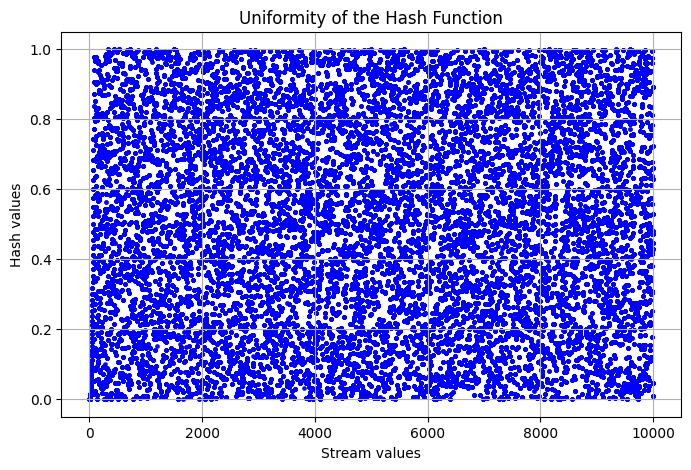

In [722]:
import matplotlib.pyplot as plt

# Prime number for the hash function, P > NUM_UNIQUE
P = 2**19 - 1

def hash_stream(stream: np.ndarray, a: int, b: int, m: int = P, normalize: bool = True, p: int = P) -> np.ndarray:
    """
    Hash the stream using the hash function (a * stream + b)^3 % p % m.
    :param stream: The stream to hash
    :param a: The slope of the hash function
    :param b: The intercept of the hash function
    :param p: The prime number for the hash function
    :param m: The range of the hash function
    :param normalize: Whether to normalize the hash values to [0, 1) or not
    :return: The hashed stream
    """
    return ((((a if a > 0 else 1) * stream + b)**3 % p) % m) / (m if normalize else 1)

# Plot the uniformity of the hash function
plt.figure(figsize=(8, 5))
plt.scatter(stream, hash_stream(stream, 1, 2), alpha=0.7, color='blue', s=5)
plt.title("Uniformity of the Hash Function")
plt.xlabel("Stream values")
plt.ylabel("Hash values")
plt.grid(True)
plt.show()

## Flajolet Martin

### Flajolet Martin - Alpha Version

In [723]:
def flajolet_martin(stream: np.ndarray, seed: int = SEED) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    a, b = np.random.default_rng(seed).integers(0, P, size=2)
    hashed_stream = hash_stream(stream, a, b)
    return 1 / np.min(hashed_stream)

### Flajolet Martin - Beta Version

In [724]:
def flajolet_martin_beta(stream: np.ndarray, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    hash_funcs = np.random.default_rng(seed).integers(0, P, size=(s, 2))
    estimates = np.array([hash_stream(stream, a, b) for a, b in hash_funcs])    
    Z = np.min(estimates, axis=1)
    return 1 / np.mean(Z) - 1

Sketch sizes: [1, 2, 4, 8, 16, 32, 64]


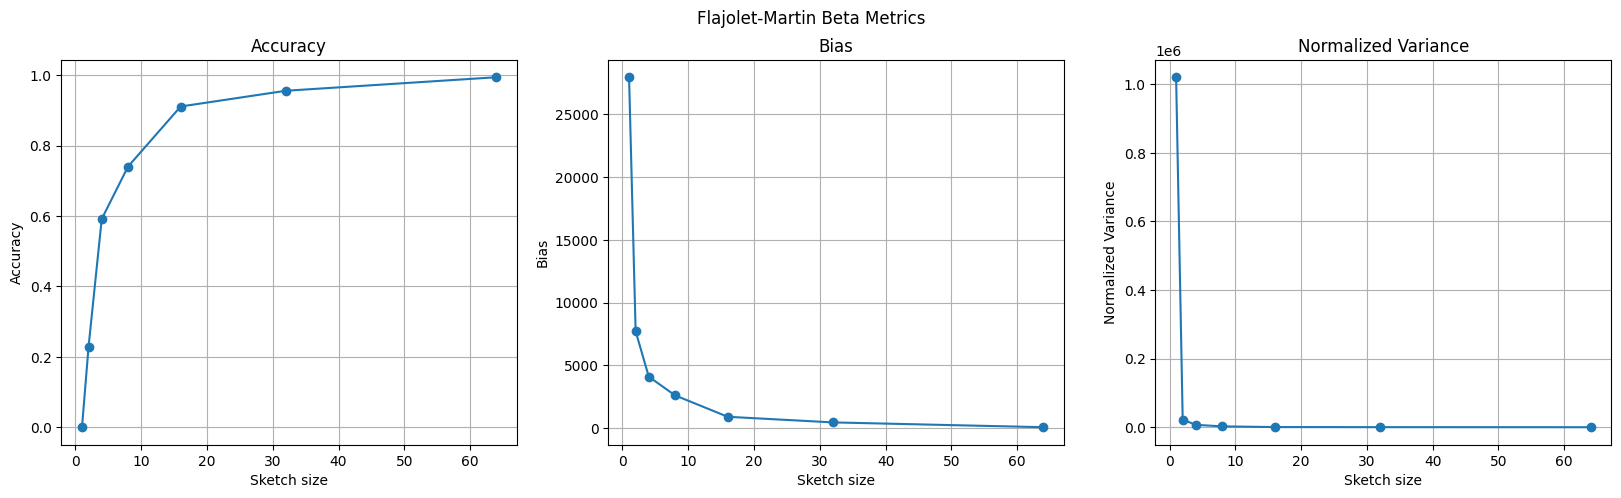

In [780]:
import matplotlib.pyplot as plt

S = [1, 2, 4, 8, 16, 32, 64]
print(f"Sketch sizes: {S}")

results = {s: [flajolet_martin_beta(stream, s, i) for i in range(NUM_RUNS)] for s in S}

def calculate_fm_metrics(results: dict) -> dict:
    """
    Calculate the metrics for the Flajolet-Martin Beta algorithm.
    :param results: Dictionary with the results
    :return: Dictionary with the metrics
    """
    metrics = {}
    for sketch_size, ests in results.items():
        mean = np.mean(ests)
        accuracy = max(0, 1 - np.abs(mean - NUM_UNIQUE) / NUM_UNIQUE)
        bias = np.abs(mean - NUM_UNIQUE)
        normalized_variance = np.var(ests) / NUM_UNIQUE
        metrics[sketch_size] = {
            "accuracy": accuracy,
            "bias": bias,
            "normalized_variance": normalized_variance
        }
    return metrics

def plot_metrics(metrics: dict, title: str, logx: bool = False):
    """
    Plot the metrics for the Flajolet-Martin Beta algorithm.
    :param metrics: Dictionary with the metrics
    :param title: Title of the plot
    """
    sketch_sizes = list(metrics.keys())
    
    plt.figure(figsize=(20, 5))
    plt.suptitle(title)

    plt.subplot(1, 3, 1)
    plt.plot(sketch_sizes, [metrics[s]["accuracy"] for s in sketch_sizes], marker='o')
    plt.title("Accuracy")
    plt.xlabel("Sketch size")
    if logx:
        plt.xscale("log")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(sketch_sizes, [metrics[s]["bias"] for s in sketch_sizes], marker='o')
    plt.title("Bias")
    plt.xlabel("Sketch size")
    if logx:
        plt.xscale("log")
    plt.ylabel("Bias")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(sketch_sizes, [metrics[s]["normalized_variance"] for s in sketch_sizes], marker='o')
    plt.title("Normalized Variance")
    plt.xlabel("Sketch size")
    if logx:
        plt.xscale("log")
    plt.ylabel("Normalized Variance")
    plt.grid(True)

    plt.show()

metrics = calculate_fm_metrics(results)
plot_metrics(metrics, "Flajolet-Martin Beta Metrics")

### Flajolet Martin - Final Version

In [726]:
def flajolet_martin_final(stream: np.ndarray, t: int, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :param seed: seed for the random number generator
    :return: median of the distinct element estimates
    """
    hash_funcs = np.random.default_rng(seed).integers(0, P, size=(t, s, 2))
    
    Zs = [np.min([hash_stream(stream, a, b) for a, b in hash_funcs[i]], axis=1) for i in range(t)]
    estimates = [1 / np.mean(Z) - 1 for Z in Zs]
        
    return np.median(estimates)

Sketch sizes: ['1 x 1 = 1', '1 x 5 = 5', '1 x 10 = 10', '5 x 5 = 25', '5 x 10 = 50', '10 x 10 = 100']


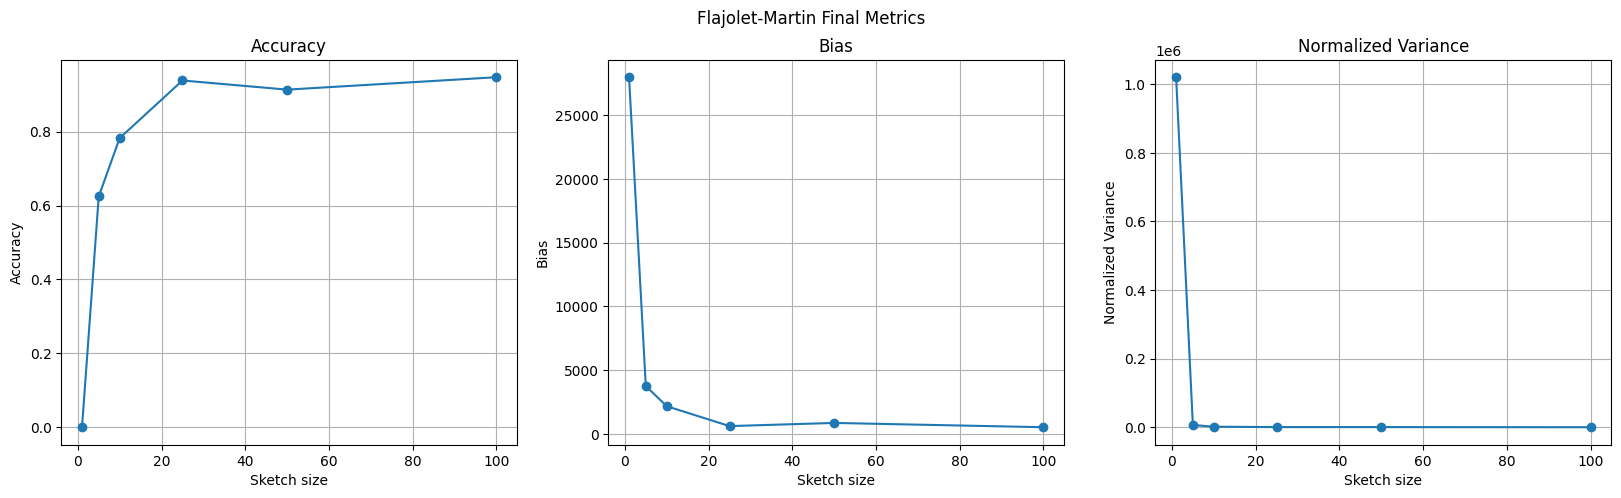

In [727]:
TS = [(1, 1), (1, 5), (1, 10), (5, 5), (5, 10), (10, 10)]
print(f"Sketch sizes: {[f'{t} x {s} = {t * s}' for t, s in TS]}")

results = {t * s: [flajolet_martin_final(stream, t, s, i) for i in range(NUM_RUNS)] for t, s in TS}

metrics = calculate_fm_metrics(results)

plot_metrics(metrics, "Flajolet-Martin Final Metrics")

## Count-Min Sketch

In [775]:
def count_min_sketch(stream: np.ndarray, d: int, w: int, seed: int = SEED) -> np.ndarray:
    """
    Count-Min Sketch algorithm for counting the frequency of elements in a stream.
    :param stream: array of elements
    :param d: depth of the sketch (number of hash functions)
    :param w: width of the sketch
    :param seed: seed for the random number generator
    :return: estimated frequency of each unique element in the stream
    """
    # Initialize the sketch
    sketch = np.zeros((d, w), dtype=np.int32)
    
    # Hash each unique stream elements to d indices (one for each hash function)
    hash_funcs = np.random.default_rng(seed).integers(0, w, size=(d, 2))
    unique_elements, counts = np.unique(stream, return_counts=True)
    unique_element_to_indices = np.array([[int(val) for val in hash_stream(unique_elements, a, b, w, normalize=False)] for a, b in hash_funcs]).T
    assert unique_element_to_indices.shape == (len(unique_elements), d), f"Unique element to indices shape: {unique_element_to_indices.shape}"
    
    # According to each unique element frequency (count), update the sketch at the hashed indices
    np.add.at(sketch, (np.arange(d)[:, None], unique_element_to_indices.T), counts)

    # Calculate estimated frequencies for each unique element in the stream
    freqs = np.array([np.min([sketch[j, unique_element_to_indices[i, j]] for j in range(d)]) for i in range(len(unique_elements))])
    
    return freqs

Sketch sizes: ['1 x 1 = 1', '1 x 10 = 10', '1 x 100 = 100', '1 x 1000 = 1000', '1 x 10000 = 10000', '1 x 100000 = 100000', '2 x 1 = 2', '2 x 10 = 20', '2 x 100 = 200', '2 x 1000 = 2000', '2 x 10000 = 20000', '2 x 100000 = 200000']
Processed sketch size 1 x 1 = 1
Processed sketch size 1 x 10 = 10
Processed sketch size 1 x 100 = 100
Processed sketch size 1 x 1000 = 1000
Processed sketch size 1 x 10000 = 10000
Processed sketch size 1 x 100000 = 100000
Processed sketch size 2 x 1 = 2
Processed sketch size 2 x 10 = 20
Processed sketch size 2 x 100 = 200
Processed sketch size 2 x 1000 = 2000
Processed sketch size 2 x 10000 = 20000
Processed sketch size 2 x 100000 = 200000


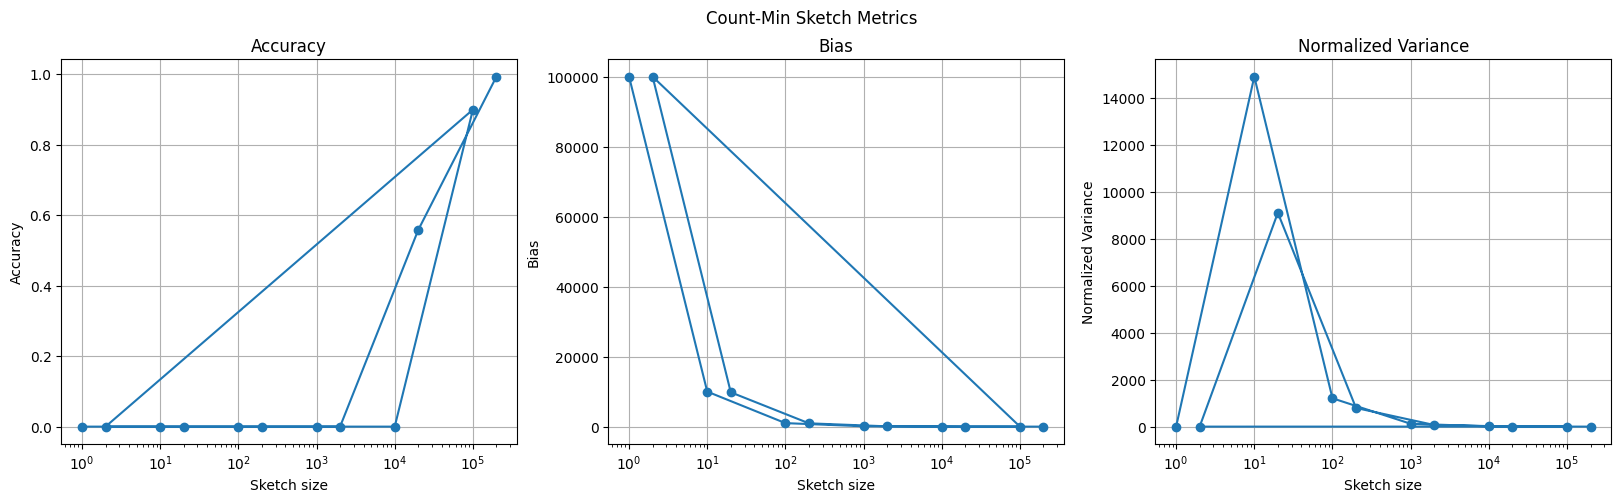

In [ ]:
DW = [(d, w) for d in [1, 2] for w in [1, 10, 100, 1000, 10000, 100000]]
print(f"Sketch sizes: {[f'{d} x {w} = {d * w}' for d, w in DW]}")

results = {d * w: [count_min_sketch(stream, d, w, i) for i in range(NUM_RUNS)] for d, w in DW}

unique_elements, counts = np.unique(stream, return_counts=True)

metrics = {}
for sketch_size, freqs_list in results.items():    
    # Accuracy (with Mean Absolute Error)
    errors = []
    for freqs in freqs_list:
        sketch_counts = np.array([freqs[i] for i, _ in enumerate(unique_elements)])
        errors.append(np.sum(np.abs(sketch_counts - counts)))
    mean_absolute_error = np.mean(errors)
    accuracy = max(0, 1 - mean_absolute_error / np.sum(counts))
    
    # Average bias, average normalized-variance
    biases = []
    variances = []
    for i, _ in enumerate(unique_elements):
        estimates = np.array([freqs[i] for freqs in freqs_list])
        true_count = counts[i]
        bias = np.mean(estimates) - true_count
        variance = np.var(estimates) / true_count
        biases.append(bias)
        variances.append(variance)
    
    avg_bias = np.mean(np.abs(biases))
    avg_normalized_variance = np.mean(variances)
    
    metrics[sketch_size] = {
        "accuracy": accuracy,
        "bias": avg_bias,
        "normalized_variance": avg_normalized_variance
    }
    
plot_metrics(metrics, "Count-Min Sketch Metrics", logx=True)